In [190]:
%matplotlib inline

from facenet_pytorch import MTCNN, InceptionResnetV1
from matplotlib import pyplot as plt
import torch
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

In [45]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN()

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [47]:
fig = plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

In [52]:
original = plt.imread('data/florian.jpg')
ben = plt.imread('data/train/mindy_kaling/httpgonetworthcomwpcontentuploadsthumbsjpg.jpg')
flo1 = plt.imread('data/florian3.jpg')
flo2 = plt.imread('data/florian4.jpg')

In [53]:
img_cropped_flo = mtcnn.forward(original)
img_cropped_ben = mtcnn.forward(ben)
img_cropped_flo1 = mtcnn.forward(flo1)
img_cropped_flo2 = mtcnn.forward(flo2)

In [54]:
embeddings = []

img_embedding_flo = resnet(img_cropped_flo.unsqueeze(0)).detach()
img_embedding_ben = resnet(img_cropped_ben.unsqueeze(0)).detach()
img_embedding_flo1 = resnet(img_cropped_flo1.unsqueeze(0)).detach()
img_embedding_flo2 = resnet(img_cropped_flo2.unsqueeze(0)).detach()

embeddings.append(img_embedding_ben)
embeddings.append(img_embedding_flo1)
embeddings.append(img_embedding_flo2)

In [55]:
print(img_embedding_flo)

tensor([[ 0.0367,  0.0382, -0.0372, -0.0024,  0.0550, -0.0105, -0.0120, -0.0072,
         -0.0004, -0.0175, -0.0035, -0.0460,  0.0387, -0.0064, -0.0780, -0.0413,
         -0.0800,  0.0036,  0.0465,  0.0344,  0.0435,  0.0414, -0.0553, -0.0314,
          0.0511, -0.0362,  0.0875, -0.0263,  0.0179, -0.0643,  0.0275,  0.0053,
         -0.0097,  0.0689,  0.0758, -0.0096,  0.0025,  0.0670, -0.0309, -0.0615,
         -0.0607,  0.0031,  0.0040, -0.0115, -0.1113, -0.0372, -0.0732, -0.0180,
         -0.0326,  0.0075,  0.0137, -0.0790,  0.0398,  0.0272,  0.0290,  0.0396,
          0.0243,  0.0189, -0.0069,  0.0263,  0.1089, -0.0129,  0.0532, -0.0066,
          0.0095, -0.0404,  0.0606,  0.0326,  0.0518, -0.0141, -0.0780, -0.0873,
         -0.0029,  0.0293,  0.0757, -0.0499, -0.0448,  0.0474,  0.0631, -0.0064,
         -0.0185,  0.0123,  0.0461, -0.0059, -0.0699,  0.0087,  0.0362, -0.0497,
         -0.0198,  0.0453, -0.0253,  0.0553, -0.0278,  0.0308, -0.0451, -0.0135,
          0.0698, -0.0522, -

In [137]:
similarities = []

for embedding in embeddings:
    score = np.linalg.norm(img_embedding_flo - embedding, 2)
    similarities.append(score)

Text(0.5, 1.0, 'Compared')

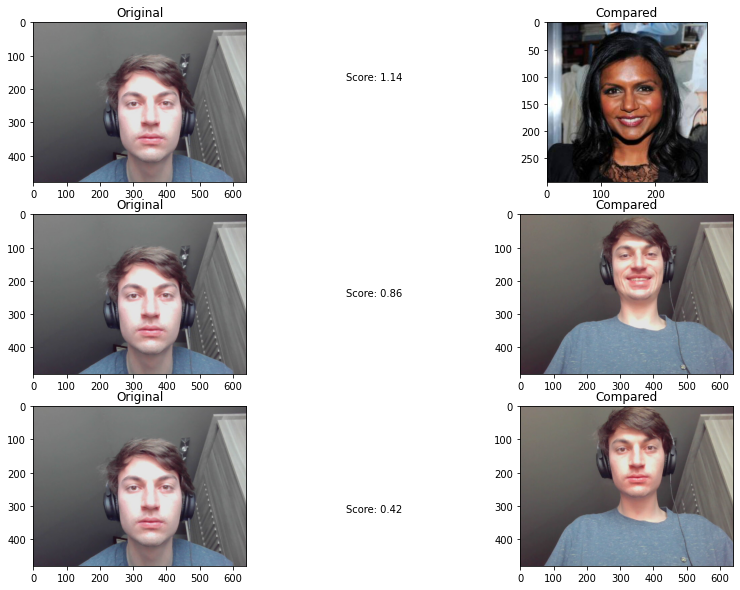

In [138]:
fig = plt.figure(figsize=(16, 10))
fig.text(0.48, 0.8, f'Score: {similarities[0]:.2f}')
fig.text(0.48, 0.5, f'Score: {similarities[1]:.2f}')
fig.text(0.48, 0.2, f'Score: {similarities[2]:.2f}')

a = fig.add_subplot(3, 2, 1)
imgplot = plt.imshow(original)
a.set_title('Original')
a = fig.add_subplot(3, 2, 2)
imgplot = plt.imshow(ben)
#imgplot.set_clim(0.0, 0.7)
a.set_title('Compared')

a = fig.add_subplot(3, 2, 3)
imgplot = plt.imshow(original)
a.set_title('Original')
a = fig.add_subplot(3, 2, 4)
imgplot = plt.imshow(flo1)
#imgplot.set_clim(0.0, 0.7)
a.set_title('Compared')

a = fig.add_subplot(3, 2, 5)
imgplot = plt.imshow(original)
a.set_title('Original')
a = fig.add_subplot(3, 2, 6)
imgplot = plt.imshow(flo2)
#imgplot.set_clim(0.0, 0.7)
a.set_title('Compared')

In [117]:
def load_embeddings(file):
    face = plt.imread(file)
    face_cropped = MTCNN().forward(face)
    return InceptionResnetV1(pretrained='vggface2').eval().forward(face_cropped.unsqueeze(0)).detach().numpy()

def load_data(directory):
    X, y = [], []
    
    for sub_dir in os.scandir(directory):
        features = []
        if not sub_dir.is_dir():
            continue
        for file in os.scandir(f'{directory}/{sub_dir.name}'):
            if file.is_dir():
                continue
            features.append(load_embeddings(file.path).reshape(1))
        
        labels = [sub_dir.name for _ in range(len(features))]
        X = X + features
        y = y + labels

    return X, y

In [107]:
X_train, y_train = load_data('data/train')

In [108]:
X_test, y_test = load_data('data/val')

In [187]:
X_train = np.array(X_train).reshape(-1, 512)
X_test = np.array(X_test).reshape(-1, 512)

In [185]:
dataset = pd.DataFrame(X_train)
dataset['label'] = y_train
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
86,0.010188,-0.044051,0.048872,0.019336,0.022796,-0.075544,-0.023706,-0.031362,0.024784,0.006086,...,-0.013817,0.049847,-0.000773,0.025998,0.045042,-0.009576,-0.015803,-0.000630,-0.011753,elton_john
87,0.059697,-0.021907,0.022449,0.035501,-0.023426,-0.020336,-0.077922,-0.023371,0.022243,-0.045454,...,-0.010431,0.032920,-0.013363,-0.005809,0.063979,0.006565,0.000226,-0.001452,-0.030734,elton_john
88,-0.003224,-0.027214,-0.011694,0.010410,0.011249,-0.025876,-0.016339,-0.017834,0.064688,0.002656,...,0.028446,0.031363,0.012513,-0.001897,-0.016844,0.078545,0.006091,-0.049187,0.003398,elton_john
89,0.064602,-0.059031,0.041844,0.003795,-0.063276,0.003138,-0.107609,-0.007271,-0.050605,-0.097759,...,-0.040690,0.056738,0.002885,0.026842,0.078900,0.004538,0.000939,0.066794,-0.023792,elton_john
90,0.018609,0.015564,0.065870,-0.011948,-0.028306,-0.009379,-0.051358,-0.000281,0.004697,-0.044049,...,-0.029931,0.038389,-0.004712,0.070700,0.050999,-0.019244,0.033388,-0.017583,-0.012402,elton_john


In [201]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_preds = knn.predict(X_test)
print(metrics.confusion_matrix(y_test, y_preds))
print(metrics.classification_report(y_test, y_preds))
print('accuracy op test set:', metrics.accuracy_score(y_test, y_preds) * 100)
print('accuracy op train set', metrics.accuracy_score(y_train, knn.predict(X_train)) * 100)

[[4 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 3 0]
 [0 0 0 0 5]]
                precision    recall  f1-score   support

    ben_afflek       1.00      1.00      1.00         4
    elton_john       1.00      1.00      1.00         5
jerry_seinfeld       1.00      1.00      1.00         5
       madonna       1.00      1.00      1.00         3
  mindy_kaling       1.00      1.00      1.00         5

      accuracy                           1.00        22
     macro avg       1.00      1.00      1.00        22
  weighted avg       1.00      1.00      1.00        22

accuracy op test set: 100.0
accuracy op train set 100.0
